In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

import lightning as L
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import DeviceStatsMonitor
from lightning.pytorch.callbacks import BasePredictionWriter
from lightning.pytorch.profilers import PyTorchProfiler

In [2]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
    self.X = torch.tensor(X).float()
    self.y = torch.tensor(y).float()
    self.seq_len = seq_len

  def __len__(self):
    return self.X.__len__() - (self.seq_len-1)

  def __getitem__(self, index):
    return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

In [3]:
class ColoradoDataModule(L.LightningDataModule):
  def __init__(self, data_dir: str, scaler: int, seq_len: int, batch_size: int, num_workers: int, is_persistent: bool):
    super().__init__()
    self.data_dir = data_dir
    self.scaler = scaler
    self.seq_len = seq_len
    self.batch_size = batch_size
    self.num_workers = num_workers
    self.is_persistent = is_persistent
    self.X_train = None
    self.y_train = None
    self.X_val = None
    self.y_val = None
    self.X_test = None
    self.y_test = None

  def setup(self, stage: str):
    df = pd.read_csv(self.data_dir)
    df.index = df['Start_DateTime']
    df = df[['Start_DateTime', 'Energy_Consumption']].sort_index()
    df.dropna(inplace=True)
    df['Start_DateTime'] = pd.to_datetime(df['Start_DateTime'], format='%Y-%m-%d %H:%M:%S')
    df.set_index('Start_DateTime', inplace=True)
    X = df.copy()
    y = X['Energy_Consumption'].shift(-1).ffill()
    X_tv, self.X_test, y_tv, self.y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_tv, y_tv, test_size=0.25, shuffle=False)
    
    preprocessing = self.scaler
    preprocessing.fit(self.X_train) # should only fit to training data
        
    if stage == "fit" or stage is None:
      self.X_train = preprocessing.transform(self.X_train)
      self.y_train = self.y_train.values.reshape((-1, 1))
      self.X_val = preprocessing.transform(self.X_val)
      self.y_val = self.y_val.values.reshape((-1, 1))

    if stage == "test" or "predict" or stage is None:
      self.X_test = preprocessing.transform(self.X_test)
      self.y_test = self.y_test.values.reshape((-1, 1))

  def train_dataloader(self):
    train_dataset = TimeSeriesDataset(self.X_train, self.y_train, seq_len=self.seq_len)
    train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return train_loader
  
  def val_dataloader(self):
    val_dataset = TimeSeriesDataset(self.X_val, self.y_val, seq_len=self.seq_len)
    val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return val_loader

  def test_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return test_loader

  def predict_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return test_loader
      

In [4]:
class CustomWriter(BasePredictionWriter):
  def __init__(self, output_dir, write_interval, model_name):
    super().__init__(write_interval)
    self.output_dir = output_dir
    self.model_name = model_name

  def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
    filename = os.path.join(self.output_dir, f"{self.model_name}/predictions_0.pt")
    i=0
    while os.path.exists(filename):
      i+=1
      filename = filename[:-4] + f"{i}.pt"

    os.makedirs(os.path.join(self.output_dir, self.model_name), exist_ok=True)
    torch.save(predictions, filename)

In [5]:
class LightningModel(L.LightningModule):
  def __init__(self, model, criterion, optimizer, learning_rate):
    super().__init__()
    self.criterion = criterion
    self.learning_rate = learning_rate
    self.optimizer = optimizer
    self.model = model

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    train_loss = self.criterion(y_hat, y) 
    self.log("train_loss", train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return train_loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    val_loss = self.criterion(y_hat, y)
    self.log("val_loss", val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    test_loss = self.criterion(y_hat, y)
    self.log("test_loss", test_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return test_loss

  def predict_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    return y_hat

  def configure_optimizers(self):
    return self.optimizer(self.parameters(), lr=self.learning_rate)

In [6]:
class MLP(torch.nn.Module):
  def __init__(self, num_features, seq_len, num_classes):
    super().__init__()

    self.all_layers = torch.nn.Sequential(
      torch.nn.Linear(num_features, seq_len),
      torch.nn.ReLU(),
      torch.nn.Linear(seq_len, 25),
      torch.nn.ReLU(),
      torch.nn.Linear(25, num_classes),
    )

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    logits = self.all_layers(x)
    return logits

In [7]:
class LSTM(torch.nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])  # Get the last time step
    return out

In [8]:
class GRU(torch.nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, criterion, dropout, learning_rate):
    super().__init__()
    self.dropout = dropout
    self.criterion = criterion
    self.learning_rate = learning_rate
    self.lstm = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])  # Get the last time step
    return out

In [9]:
params = dict(
  model_name = "LSTM",
  seq_len = 12,
  batch_size = 8,
  criterion = nn.MSELoss(),
  optimizer = torch.optim.Adam,
  max_epochs = 1000,
  n_features = 7,
  hidden_size = 100,
  num_layers = 1,
  dropout = 0, # can be 0.2 if more output layers are present
  learning_rate = 0.001,
  num_workers = 0, # only work in .py for me
  is_persistent = False, # only work in .py for me
  scaler = MinMaxScaler()
)

## Runs

Lightning

In [10]:
colmod = ColoradoDataModule(data_dir='ColoradoData_Boulder.csv', scaler=params['scaler'], seq_len=params['seq_len'], batch_size=params['batch_size'], num_workers=params['num_workers'], is_persistent=params['is_persistent'])


# _model = MLP(num_features=params['seq_len'], seq_len=params['batch_size'], num_classes=1)
# _model = GRU(input_size=1, hidden_size=params['hidden_size'], num_layers=params['num_layers'], criterion=params['criterion'], dropout=params['dropout'], learning_rate=params['learning_rate'])
_model = LSTM(input_size=1, hidden_size=params['hidden_size'], num_layers=params['num_layers'], dropout=params['dropout'])
model = LightningModel(model=_model, criterion=params['criterion'], optimizer=params['optimizer'], learning_rate=params['learning_rate'])
pred_writer = CustomWriter(output_dir="Predictions", write_interval="epoch", model_name=params['model_name'])

trainer = L.Trainer(max_epochs=params['max_epochs'], callbacks=[EarlyStopping(monitor="val_loss", mode="min"), pred_writer])
trainer.fit(model, colmod)
trainer.test(model, colmod)
trainer.predict(model, colmod, return_predictions=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | model     | LSTM    | 41.3 K | train
----------------------------------------------
41.3 K    Trainable params
0         Non-trainable params
41.3 K    Total params
0.165     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

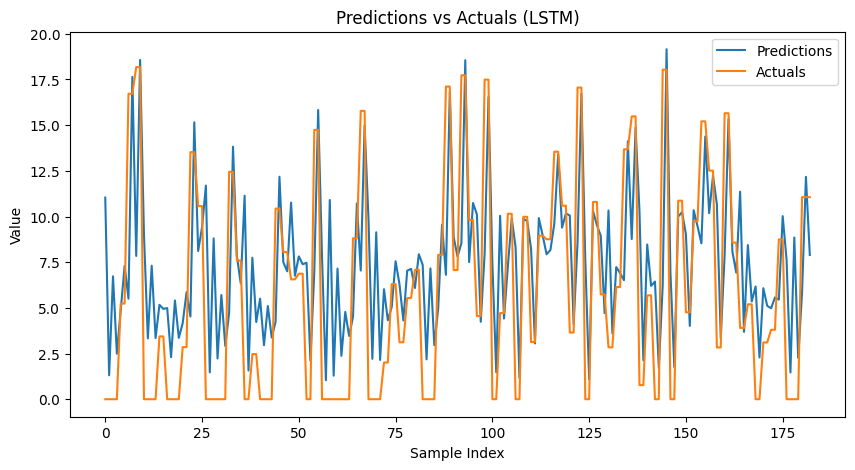

In [ ]:
predictions = torch.load(f'Predictions/{params['model_name']}/predictions_1.pt')

actuals = []
for batch in colmod.predict_dataloader():
  x, y = batch
  actuals.extend(y.numpy())

# Flatten the predictions and actuals
predictions_flat = [item.item() for sublist in predictions for item in sublist]
actuals_flat = [item for sublist in actuals for item in sublist]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(predictions_flat, label='Predictions')
plt.plot(actuals_flat, label='Actuals')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title(f'Predictions vs Actuals ({params["model_name"]})')
plt.legend()
plt.show()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=Models/lightning_logs/  

Reusing TensorBoard on port 6006 (pid 10736), started 0:34:57 ago. (Use '!kill 10736' to kill it.)

In [ ]:
!tasklist | findstr tensorboard # find tensorboard pid
# !taskkill /PID 16220 /F # kill tensorboard with pid

tensorboard.exe              16220 Console                    3         48 K
SUCCESS: The process with PID 16220 has been terminated.
